In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [3]:
from tensorflow.keras.models import Sequential    # These are the only parts of keras we need, so we don't need to import tensorflow/full keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
from matplotlib import pyplot
from matplotlib import figure

In [5]:
from math import sqrt
from math import pow
from numpy import concatenate
from scipy.signal import savgol_filter

In [6]:
dataset = pd.read_csv('../data/clean_data/df260_fewerCols.csv', header=0, index_col=0)

value = dataset.to_numpy()
value.shape

(7439, 32)

In [7]:
dataset.head()

Date  Wind_Direction_Vector  Avg_Temp  Min_Temp  Min_Temp_Hour  \
  STN                                                                         
260    01/01/2000                    237        61        35             19   
260    02/01/2000                    205        73        54              1   
260    03/01/2000                    212        84        64             24   
260    04/01/2000                    231        64        43              8   
260    05/01/2000                    191        44        14              9   

       Max_Temp  Max_Temp_Hour  Min_Temp_at_10cm  Min_Temp_at_10cm_Hour  \
  STN                                                                     
260          81             12               -20                     24   
260          87             18                43                      6   
260          96             13                65                     24   
260          94             16                27                     24   
260          74             14               -21                     12   

       Sunshine_Duration_by_radiation  ...  \
  STN                                  ...   
260                                 0  ...   
260                                 0  ...   
260                                 0  ...   
260                                 0  ...   
260                                65  ...   

       Minimum_encountered_visibility_hour  Maximum_encountered_visibility  \
  STN                                                                        
260                                      9                              63   
260                                      6                              50   
260                                     16                              62   
260                                     10                              80   
260                                      9                              75   

       Maximum_encountered_visibility_hour  Time_average_cloud_cover  \
  STN                                                                  
260                                     14                         7   
260                                     24                         8   
260                                      3                         8   
260                                     23                         7   
260                                      1                         3   

       Time_average_relative_humidity(percent)  \
  STN                                            
260                                         97   
260                                         97   
260                                         94   
260                                         94   
260                                         90   

       Maximum_relative_humidity(percent)  Maximum_relative_humidity_hour  \
  STN                                                                       
260                                    99                               9   
260                                    99                               1   
260                                    97                              15   
260                                    99                              10   
260                                    95                               8   

       Minimum_relative_humidity(percent)  Minimum_relative_humidity_hour  \
  STN                                                                       
260                                    93                              16   
260                                    93                              22   
260                                    90                              11   
260                                    83                              23   
260                                    82                              14   

        Reference_crop_evaporation  
  STN                               
260                              1  
260             

Graphicalisation of the data

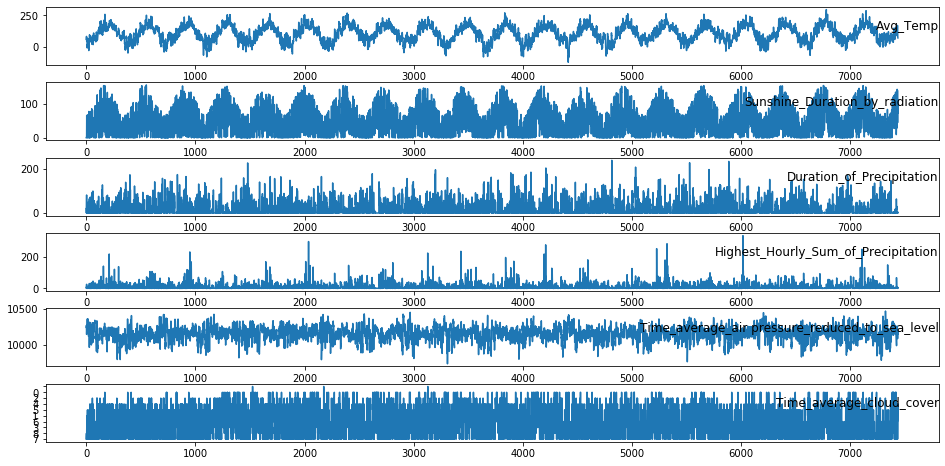

In [8]:
groups = [2,9,12,14,16,25]
i = 1
# plot each column
pyplot.figure(figsize=(16,8))       # Increase the size of the plot
pyplot.subplots_adjust(hspace=0.3)  # Increase the space between plots
for group in groups:

    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(value[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1

pyplot.show()

Deleting some non usable rows

In [8]:
values = np.delete(value,0,1) #deleting the data, since it wont help predicting
values = np.delete(values,24,1) # deleting this column due to inconsistency  
values_backup = values.copy()

# Run code once:

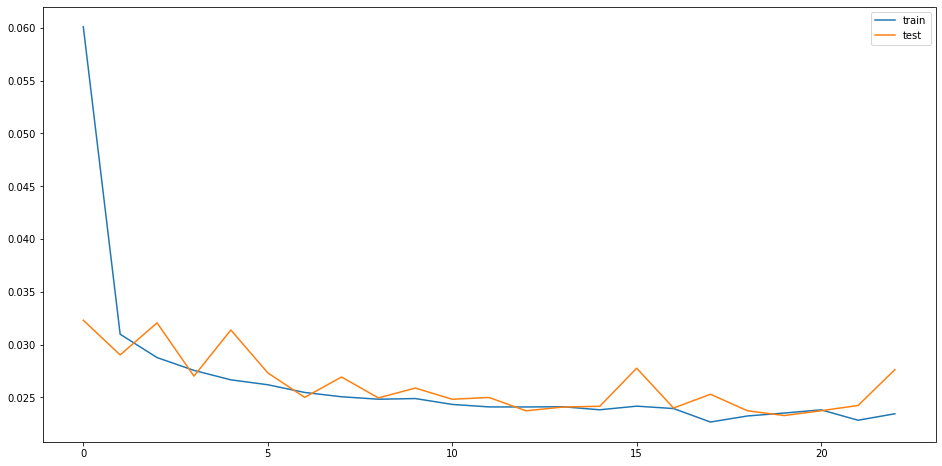

MAE:  8.522884


In [14]:
values = values_backup.copy()
train_X, test_y, test_X, train_y,  scaler = preprocess_for_LSTM(values)
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                        verbose=0, mode='auto', restore_best_weights=True)

# fit network
history = model.fit(train_X, train_y, epochs=100, callbacks=[monitor],
                    validation_data=(test_X, test_y), verbose=0, batch_size=32)


# plot history
pyplot.figure(figsize=(16,8))       # Increase the size of the plot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()




print ("MAE: " , evaluation(test_X, test_y, model, scaler))

In [14]:
def plot_smoothing(pre_smooth, after_smooth):

    pyplot.rcParams.update({'font.size': 30})
    fig = pyplot.figure(1, figsize=(16,9))
    ax = fig.add_subplot(1,1,1)
    ax.plot(pre_smoth[:365], label = "Before smoothing")
    ax.plot(after_smoth[:365], label = "After smoothing")


    pyplot.xlabel("Day")
    pyplot.ylabel("Daily average temperature (in 0.1°C)")
    pyplot.legend()

    pyplot.savefig("effectOfSmoothening.pdf")
    pyplot.show()


In [15]:
def plot_observed_predicted_values(inv_y, inv_yhat, time = 61):
    pyplot.rcParams.update({'font.size': 30})
    fig = pyplot.figure(1, figsize=(16,9))
    ax = fig.add_subplot(1,1,1)
    ax.plot(inv_y[:time], label = "Observed outcome")
    ax.plot(inv_yhat[:time], label = "Predicted outcome")


    pyplot.xlabel("Day")
    pyplot.ylabel("Daily average temperature (in 0.1°C)")
    pyplot.legend()
    pyplot.show()





The mae between any day n and day n+1 in 0.1°C

In [10]:
def dif_per_day(inv_y):
    dif_per_day = [0] * 7

    for i in range(1,8):

        left = inv_y[:len(inv_y)-i]
        right = inv_y[i:]
        test_rmse= mean_absolute_error(left,right)
        dif_per_day[i-1] = test_rmse

    print(dif_per_day)
    return dif_per_day

# Trying out the best LSTM internal node size
## Takes a lot of time

In [125]:
RMSE1 = [0] * 30 # Testing 30 different LSTM sizes 
repetitions = 2

for j in range (repetitions):
    counter = 0
    for i in range(1, 150, 5):
        
        values = values_backup
        train_X, test_y, test_X, train_y, scaler = preprocess_for_LSTM(values)

        model = Sequential()
        model.add(LSTM(i, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                                verbose=1, mode='auto', restore_best_weights=True)

        # fit network
        history = model.fit(train_X, train_y, epochs=100, callbacks=[monitor],
                            validation_data=(test_X, test_y), verbose=0, batch_size=32)

        # calculate RMSE
        rmse = evaluation(test_X, test_y, model, scaler)
        RMSE1[counter] = RMSE1[counter] + rmse 
        print("j: ", j, "  i: ", i, "  counter: ", counter, "  new value: ", RMSE1[counter])
        counter += 1
        
final = [0] * 30
for i in range(30):
    final[i] = RMSE1[i]/repetitions
import matplotlib.ticker as mtick
x_values = np.linspace(5,150,len(final))

fig = pyplot.figure(1, figsize=(16,9))
ax = fig.add_subplot(1,1,1)
ax.plot(x_values, final, label = "RMSE")
pyplot.xlabel("Number of LSTM neurons")
pyplot.ylabel("RMSE of the model")
pyplot.legend()

pyplot.show()

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
j:  0   i:  1   counter:  0   new value:  16.96436029632924
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
j:  0   i:  6   counter:  1   new value:  16.512554594262987
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
j:  0   i:  11   counter:  2   new value:  16.43405474974384
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
j:  0   i:  16   counter:  3   new value:  16.336836043556982
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
j:  0   i:  21   counter:  4   new value:  16.266143761240034
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
j:  0   i:  26   counter:  5   new value:  16.117472466276215
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
j:  0   i:  31   counter:  6   new value:  1

Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
j:  1   i:  131   counter:  26   new value:  32.73587305201501
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
j:  1   i:  136   counter:  27   new value:  32.12759791798861
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
j:  1   i:  141   counter:  28   new value:  31.980914114996853
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
j:  1   i:  146   counter:  29   new value:  32.16841526688717
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
j:  2   i:  1   counter:  0   new value:  50.6924517016718
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
j:  2   i:  6   counter:  1   new value:  48.702549724735114
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
j:  2   i:  11   counter:  2   new valu

j:  3   i:  111   counter:  22   new value:  65.01657947194343
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
j:  3   i:  116   counter:  23   new value:  64.75610645506919
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
j:  3   i:  121   counter:  24   new value:  64.23465872345217
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
j:  3   i:  126   counter:  25   new value:  63.75790892594067
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
j:  3   i:  131   counter:  26   new value:  65.09666688794442
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
j:  3   i:  136   counter:  27   new value:  64.2463635182981
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
j:  3   i:  141   counter:  28   new value:  63.6779533213762
Restoring model weights from the end of the best epoch.
E

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
j:  5   i:  96   counter:  19   new value:  96.74312923621392
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
j:  5   i:  101   counter:  20   new value:  97.30286957899698
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
j:  5   i:  106   counter:  21   new value:  95.9985960825528
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
j:  5   i:  111   counter:  22   new value:  96.78696734771209
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
j:  5   i:  116   counter:  23   new value:  97.01258175266204
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
j:  5   i:  121   counter:  24   new value:  96.3605423571672
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
j:  5   i:  126   counter:  25   new 

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
j:  7   i:  76   counter:  15   new value:  127.99019949732208
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
j:  7   i:  81   counter:  16   new value:  128.2589372308629
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
j:  7   i:  86   counter:  17   new value:  128.66092015597349
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
j:  7   i:  91   counter:  18   new value:  128.28058718169163
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
j:  7   i:  96   counter:  19   new value:  128.62254980308114
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
j:  7   i:  101   counter:  20   new value:  129.1619155388546
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
j:  7   i:  106   counter:  21   ne

Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
j:  9   i:  56   counter:  11   new value:  159.95663914040608
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
j:  9   i:  61   counter:  12   new value:  160.62168333069678
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
j:  9   i:  66   counter:  13   new value:  161.08979510256657
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
j:  9   i:  71   counter:  14   new value:  160.620616081219
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
j:  9   i:  76   counter:  15   new value:  160.7748637367742
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
j:  9   i:  81   counter:  16   new value:  159.83754681165095
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
j:  9   i:  86   counter:  17   new v

# FINAL DEMO
## Also fairly time consuming 

In [15]:
rep = 10
all_MAE = [0] * 7 # predicted the temperature for the next week 

for j in range(1,8):
    mae = 0
    sub_MAE = [0] * rep

    for i in range(rep):
        values = values_backup.copy()
        train_X, test_y, test_X, train_y,  scaler = preprocess_for_LSTM(values, days_in_adv = j)
        model = Sequential()
        model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                                verbose=0, mode='auto', restore_best_weights=True)

        # fit network
        history = model.fit(train_X, train_y, epochs=100, callbacks=[monitor],
                            validation_data=(test_X, test_y), verbose=0, batch_size=32)

        sub_MAE[i] = evaluation(test_X, test_y, model, scaler)

    all_MAE[j-1] = sub_MAE
    print(all_MAE)
    
  

[[237 61 35 ... 93 16 1]
 [205 73 54 ... 93 22 1]
 [212 84 64 ... 90 11 0]
 ...
 [15 84 37 ... 33 16 31]
 [289 77 7 ... 38 17 28]
 [9 72 2 ... 44 17 24]]
[[8.387884, 8.522025, 8.382338, 8.717041, 8.645448, 8.423001, 8.829201, 8.675511, 8.7407465, 8.453234], 0, 0, 0, 0, 0, 0]
[[8.387884, 8.522025, 8.382338, 8.717041, 8.645448, 8.423001, 8.829201, 8.675511, 8.7407465, 8.453234], [15.116421, 15.356238, 14.962859, 15.009232, 15.072482, 15.290981, 15.116694, 14.814598, 14.903948, 14.917761], 0, 0, 0, 0, 0]
[[8.387884, 8.522025, 8.382338, 8.717041, 8.645448, 8.423001, 8.829201, 8.675511, 8.7407465, 8.453234], [15.116421, 15.356238, 14.962859, 15.009232, 15.072482, 15.290981, 15.116694, 14.814598, 14.903948, 14.917761], [19.824326, 19.92247, 19.817478, 19.621956, 20.002304, 19.753918, 19.557867, 19.60674, 19.612246, 19.75707], 0, 0, 0, 0]
[[8.387884, 8.522025, 8.382338, 8.717041, 8.645448, 8.423001, 8.829201, 8.675511, 8.7407465, 8.453234], [15.116421, 15.356238, 14.962859, 15.009232, 15.0724

printing the mean difference in MAE and the standerd deviation of it as well

In [16]:
mean_MAE = [0]*7
stdev_MAE = [0]* 7
for i in range (7):
    # TODO has to be changed back
    mean_MAE[i] = sum(all_MAE[i])/rep
    stdev_MAE[i] = np.std(all_MAE[i])

print(mean_MAE)
print(stdev_MAE)

[8.577642917633057, 15.056121444702148, 19.7476375579834, 22.31465263366699, 23.259411239624022, 23.582784843444824, 23.93019371032715]
[0.15496105, 0.16258308, 0.14010717, 0.17248692, 0.15252633, 0.14345917, 0.14699213]


Plots the mena change of temperature against the mean change of the predicted values 

[16.012772250605, 23.609385504907895, 27.126008606777837, 29.310558170813717, 31.005515200430455, 32.08287367146509, 32.936625403659846]


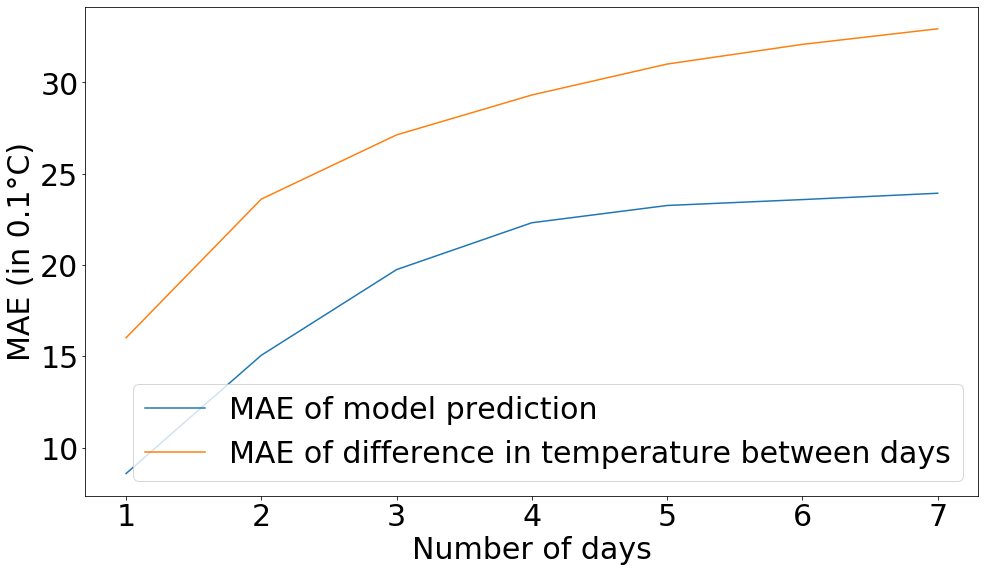

In [18]:
dif_per_day = dif_per_day(values[:,1])
days =[1,2,3,4,5,6,7]
pyplot.rcParams.update({'font.size': 30})
fig = pyplot.figure(1, figsize=(16,9))
ax = fig.add_subplot(1,1,1)
ax.plot(days,mean_MAE, label = "MAE of model prediction")
ax.plot(days,dif_per_day, label = "MAE of difference in temperature between days")
ax.plot
pyplot.xlabel("Number of days")
pyplot.ylabel("MAE (in 0.1°C)")
pyplot.legend()


#pyplot.savefig("predictionOfPreviousDays.pdf")
#files.download("predictionOfPreviousDays.pdf")
pyplot.show()

# Functions

In [11]:
def preprocess_for_LSTM(values, n_train_days = 6000, days_in_adv = 1):
    values = values_backup.copy()

    # smothening temperature
    values[:,1] = savgol_filter(values[:,1], 7, 3) 


    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled,1,days_in_adv)
    reframed.drop(reframed.columns[[30,32,33,34,35,35,36,37,38,
                                    39,40,41,42,43,44,45,46,47,48,
                                    49,50,51,52,53,54,55,56,57,58,59]], axis=1, inplace=True)

    reframed.head()
    values = reframed.values
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]


    # split into input and outputs
    # In train and test the last colum includes the output, this has to be removed and added to the test/train_Y
    train_y = train[:,-1]
    train_X = np.delete(train,-1,1)

    test_y = test[:,-1]
    test_X = np.delete(test,-1,1)

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    return train_X, test_y, test_X, train_y, scaler

In [12]:
# convert series to supervised learning
def series_to_supervised(data,n_in = 1,  n_out = 1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(n_out-1, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg


In [13]:
def evaluation(test_X, test_y, model, scaler):
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate MAE

    return (mean_absolute_error(inv_y, inv_yhat))
    